In [ ]:
#The goal of this notebook is to condense the information from the lineup into a single 1 hot variable using an unsupervised method. 
#Overall the strategy is:
#1. Record the x,y positons of each presnap position for the defensive players and build a vector of field position organized by role
#i.e. [[saftey_x,saftey_y],[cb_x,cb_y],...].  Duplicate positions will be ordered by the y coordinate. Missing positions will be filled by (-1,-1) with noise for stability? 
#2. Use a GMM on the player vectors to define the type of defensive set up. 
#3. Store this addtional value as a feature for a future model.
#4. Repeat with the offensive set up.

#N.B. some of the preprocessing and organization was done by Gian Favero and Michael Montemurri



In [246]:
import numpy as np
import matplotlib.pyplot as plt
import os
import polars as pl
from sklearn import mixture
root_dir = os.getcwd()
print(root_dir)

C:\Users\chess\OneDrive\Desktop\Non PhD work\NFLbigdatabowl\BigData25\notebooks


In [325]:
#import dataset
df_raw = pl.read_csv('../data/processed/df_clean.csv')
cols_to_use = [
      'playgameID','gameId', 'playId', 'frameId', 'nflId', 'displayName',
      'position', 'club', 'possessionTeam', 'defensiveTeam',"homeTeamAbbr",
      'preSnapHomeScore', 'preSnapVisitorScore', 'quarter',
      'gameClock', 'down', 'yardsToGo', 'yardlineNumber',
      'yardlineSide', 'offenseFormation', 'receiverAlignment',
      'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
      'o_clean', 'a_clean', 's_clean', 'x_clean', 'y_clean', 'dir_clean',
      'playDescription', 'passLocationType', 'rushLocationType', 
      'pff_runConceptPrimary', 'yardsGained', 'wasInitialPassRusher', 'event',"homeTeamWinProbabilityAdded"
      ]

df = df_raw[cols_to_use]
df=df.filter(pl.col("event") == "line_set")
#Orient the win probability correctly
df=df.with_columns(pl.when(pl.col('possessionTeam')==pl.col('homeTeamAbbr')).then(pl.col("homeTeamWinProbabilityAdded")).otherwise(-1*pl.col("homeTeamWinProbabilityAdded")).alias("winPercentChange"))


In [326]:
# Group by 'gameId' and 'playId', then find the y coord of the center ('C') player
def get_center_y(group):
    center = group[1].filter(group[0]=="C")
    if not center.is_empty():
        return center[0]
    return None  # In case there's no center player

# Apply this function to each group to get the y_clean for the center player
#center_y_dict = df.group_by(['gameId', 'playId']).map_elements(get_center_y).to_dict()
center_y_dict=df.group_by(['playgameID'], maintain_order=True).agg(pl.map_groups(exprs=["position","y_clean"],function=get_center_y).alias("center_y"))
print(center_y_dict.shape)
# Map the center_y value to the dataframe based on 'gameId' and 'playId'
df = df.join(center_y_dict, on="playgameID", how="left",coalesce=True)
print(df.shape)
# Now, calculate the horizontal distance to the ball for each player
# Check if 'center_y' is assigned properly, otherwise hDist will be NaN
df = df.with_columns((pl.col("y_clean").flatten() - pl.col("center_y").flatten()).alias("hDist"))
#confirmed with animation that the hDist is correct
# Group by 'gameId' and 'playId', then find the x coord of the center ('C') player



def get_center_x(group):
    center = group[1].filter(group[0]=="C")
    if not center.is_empty():
        return center[0]
    return None  # In case there's no center player

# Apply this function to each group to get the x_clean for the center player
center_x_dict=df.group_by(['playgameID'], maintain_order=True).agg(pl.map_groups(exprs=["position","x_clean"],function=get_center_y).alias("center_x"))
df = df.join(center_x_dict, on="playgameID", how="inner", coalesce=True)

# Now, calculate the distance from the line of scrimmage for each player
df = df.with_columns((pl.col("x_clean").flatten() - pl.col("center_x").flatten()).alias("losDist"))
print(df.shape)
#confirmed with animation that these values are correct

(13407, 2)
(294953, 39)
(294953, 42)


In [327]:
print(df.columns)
# Rename positions to a common and more primary format
# Group all specified positions into the desired categories
position_mapping = {
    'FS': 'S',    # Safety (FS)
    'SS': 'S',    # Safety (SS)
    'LB': 'DE',   # Linebacker (LB) -> Defensive End (DE)
    'MLB': 'ILB', # Middle Linebacker (MLB) -> Inside Linebacker (ILB)
    'NT': 'IDL',  # Nose Tackle (NT) -> Interior Defensive Line (IDL)
    'DT': 'IDL',  # Defensive Tackle (DT) -> Interior Defensive Line (IDL)
    'DB': 'CB'    # Defensive Back (DB) -> Cornerback (CB)
}

# Grouping and renaming positions with .loc to avoid SettingWithCopyWarning
df= df.with_columns(pl.col('position').replace(position_mapping))
#df=df.select(pl.all().replace(position_mapping))
#df.loc[:, 'position'] = df['position'].replace(position_mapping)
#df = df[df['event'] == 'line_set'].copy()

['playgameID', 'gameId', 'playId', 'frameId', 'nflId', 'displayName', 'position', 'club', 'possessionTeam', 'defensiveTeam', 'homeTeamAbbr', 'preSnapHomeScore', 'preSnapVisitorScore', 'quarter', 'gameClock', 'down', 'yardsToGo', 'yardlineNumber', 'yardlineSide', 'offenseFormation', 'receiverAlignment', 'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'o_clean', 'a_clean', 's_clean', 'x_clean', 'y_clean', 'dir_clean', 'playDescription', 'passLocationType', 'rushLocationType', 'pff_runConceptPrimary', 'yardsGained', 'wasInitialPassRusher', 'event', 'homeTeamWinProbabilityAdded', 'winPercentChange', 'center_y', 'hDist', 'center_x', 'losDist']


In [274]:
#Getting the features necessary for grouping the defense
print(list(df["position"].unique()))
features = ["nflId","playgameID",'position', 'hDist', 'losDist',"yardsGained","winPercentChange"]
df_model = df.select(features)
df_model=df_model.drop_nulls()
defensive_positions=["CB","IDL","ILB","DE","S","OLB"]
defensive_df=df_model.filter(pl.col("position").is_in(defensive_positions))
defensive_df=defensive_df.drop_nulls()
defensive_df=defensive_df.select(pl.all().sort_by("position").over("playgameID"))
print(defensive_df.columns)
defensive_set_up=defensive_df.group_by('playgameID').agg(pl.col('position')).with_columns(pl.col('position').list.join(''))
#defensive_df=defensive_df.group_by('playgameID').agg(pl.col('hDist','losDist'))

['IDL', 'C', 'WR', 'FB', 'ILB', 'DE', 'QB', 'T', 'G', 'TE', 'RB', 'S', 'OLB', 'CB']
['nflId', 'playgameID', 'position', 'hDist', 'losDist', 'yardsGained', 'winPercentChange']


In [ ]:
#After much thought my general strategy to organize defensive positions into plays will be the following.
#Why is this difficult? First, there are an inconsistent number of positions between defensive formations, i.e. the defense may choose to have anywhere between 3-10 players on the D-line. I'd like to be able to consistently decide when this is a new type of play. Second, as there is no 1-1 correlation between players the vector describing the setup could be matching the wrong players. My inital thought was to sort players by y_position and go top to bottom. But this runs into a lot of problems when players are stacked near to each other along the y_axis. For example the middle linebacker (the mike) could be between the 2nd and 3rd lineman or the 3rd and 4th lineman in terms of y_axis ordering but this places them in a different spot in the array. 

#With these problems in mind I do the following.
#1.) Place the defensive players into three bands, on the line(within a few yards of the los), 
#in the secondary (between 3-8 yards), and far back (>8 yards). 
#2.) Organize each band by y_axis height. 
#3a) Make a per band GMM to describe the defensive postioning in each band. Note this will have to be done for each number of players in the band. Arguably different plays anyway
#3b) Concatenate the bands to describe the defensive positioning and use 1 GMM
#4) Add the GMM class label as a new feature. 


In [265]:
from sklearn.mixture import GaussianMixture

In [313]:
#Get the dataframes for the primary, secondary, and tertiary levels of the defense. 
primary_df=defensive_df.filter(pl.col("losDist")<=400)
secondary_df=defensive_df.filter((pl.col("losDist")>400) & (pl.col("losDist")<1000))
tertiary_df=defensive_df.filter(pl.col("losDist")>=1000)
joint_df=pl.DataFrame()
suffixes=["secondary","tertiary"]
i=-2
#Combine them together after sorting by y-axis value. This prevents y-axis swapping between levels of the defense from messing up the GMM
for evaluation_df in [primary_df,secondary_df,tertiary_df]:
    i+=1
    evaluation_df=evaluation_df.select(pl.all().sort_by("hDist").over("playgameID"))
    evaluation_df=evaluation_df.group_by('playgameID').agg(pl.col('yardsGained').first(),pl.col('winPercentChange').first(),pl.col('hDist','losDist'))
    evaluation_df=evaluation_df.with_columns(pl.col("hDist").list.len().alias("primary_players"))

    evaluation_df=evaluation_df.select(pl.all().sort_by("primary_players"))
    if joint_df.is_empty():
        joint_df=evaluation_df
    else:
        joint_df=joint_df.join(evaluation_df,on="playgameID",suffix=suffixes[i],how="left")
#Reaggreate the feature columns
joint_df=joint_df.with_columns(pl.concat_list("hDist", "hDistsecondary","hDisttertiary").alias("allhDist"))
joint_df=joint_df.with_columns(pl.concat_list("losDist", "losDistsecondary","losDisttertiary").alias("alllosDist"))
joint_df=joint_df.with_columns((pl.col("primary_players")+pl.col("primary_playerssecondary")+pl.col("primary_playerstertiary")).alias("player_totals"))
#Keep only the columns with 11 players
joint_df=joint_df.filter(pl.col("player_totals")==11)
#Keep plays with between 2 and 10 players at the lOS. Other plays are probably flukes
joint_df=joint_df.filter((pl.col("primary_players")>2) & (pl.col("primary_players")<10))



n_components=8
#Define the number of set ups we want to define
gmm_df=joint_df
gmm_df=gmm_df.select(["allhDist","alllosDist","playgameID"])
gmm_df=gmm_df.to_numpy()
#We really only want the Y features at this point. We know they are at the line of scrimmage
#Define the features and fit the GMM
#np.abs potentially to prevent reflections from being different
y_feats=np.concatenate(gmm_df[:,0]).ravel().reshape(-1,11)
x_feats=np.concatenate(gmm_df[:,1]).ravel().reshape(-1,11)
gmm_features=np.concatenate([y_feats,x_feats],1)
gm_def = GaussianMixture(n_components=n_components, random_state=0).fit(gmm_features)
defensive_set_up_assignments=gm_def.predict(gmm_features)
joint_df=joint_df.with_columns(defensive_setup=defensive_set_up_assignments)

#Plot the means for player placement
plotting=0
if plotting:
    for j in range(n_components):
        plt.figure()
        #Goes to 11 because there are 11 players on field
        plt.scatter(gm.means_[j,11:((2*11))]/100-1.6,gm.means_[j,0:11]/100)
        plt.legend(["Defensive setup"+str(j+1)])
        plt.xlabel("Yards from the line of scrimmage")
        plt.ylabel("Yaxis yards")
gmm_defensive=joint_df

In [ ]:
#Time for the offense. This should be a bit easier since the offense has less variation in player depth. 
#Most wide receivers are on the line and the backs will change slightly. 
#It should just capture the 3-1 2-2 0-3 type set ups. 
#Combining left and right variations might be useful to prevent reflections from being called differently. Something to add... 

In [314]:
offensive_positions=['RB', 'DE', 'T', 'C', 'WR', 'FB', 'QB', 'TE']
offensive_df=df_model.filter(pl.col("position").is_in(offensive_positions))
#Should be the reverse of the defense, most players are on the line. The line and backs should be sufficient
print(offensive_df["losDist"].hist(bins=[-800,-200,250,10**6]))


shape: (3, 3)
┌────────────┬──────────────────┬────────┐
│ breakpoint ┆ category         ┆ count  │
│ ---        ┆ ---              ┆ ---    │
│ f64        ┆ cat              ┆ u32    │
╞════════════╪══════════════════╪════════╡
│ -200.0     ┆ (-800.0, -200.0] ┆ 25225  │
│ 250.0      ┆ (-200.0, 250.0]  ┆ 111116 │
│ 1e6        ┆ (250.0, 1e6]     ┆ 821    │
└────────────┴──────────────────┴────────┘


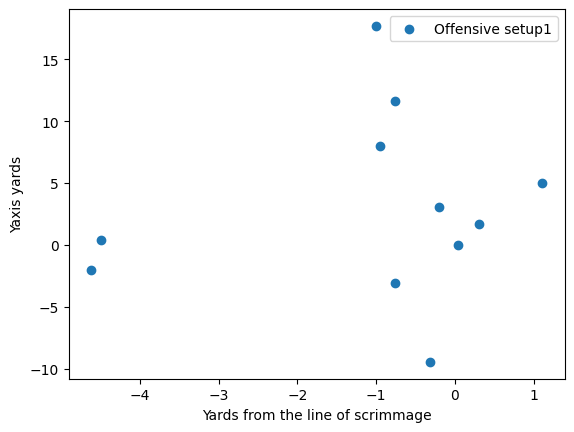

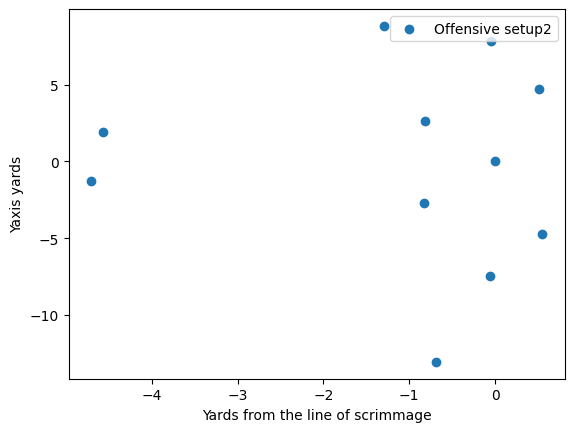

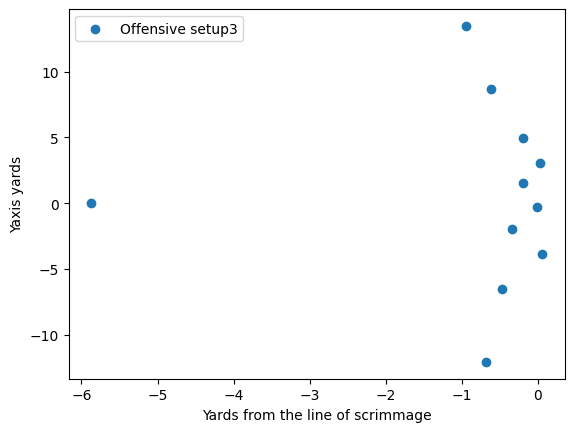

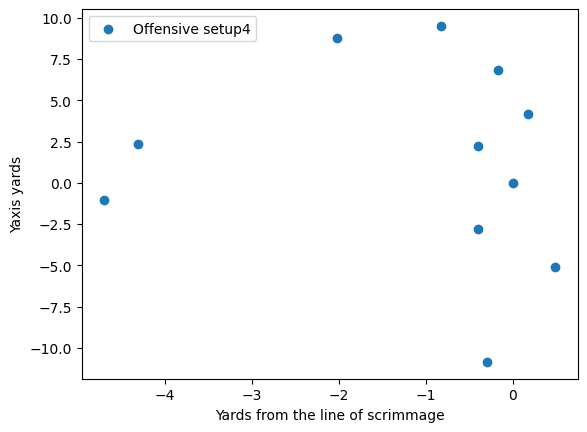

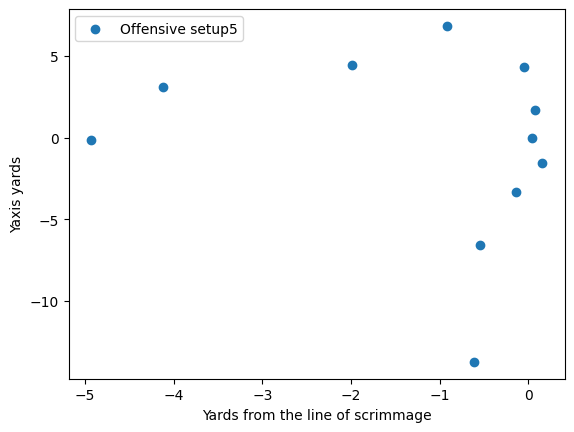

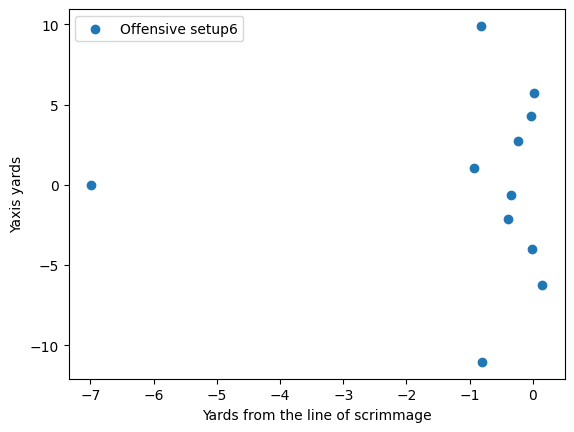

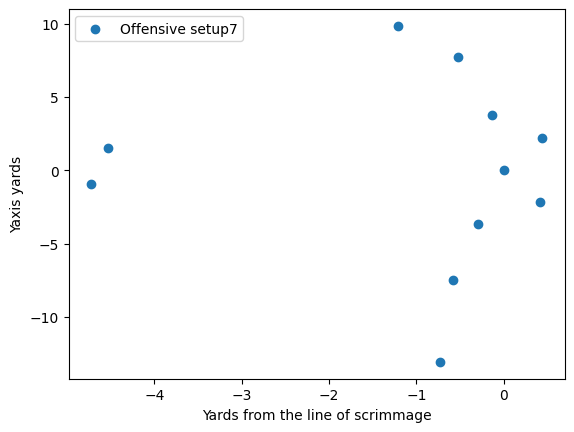

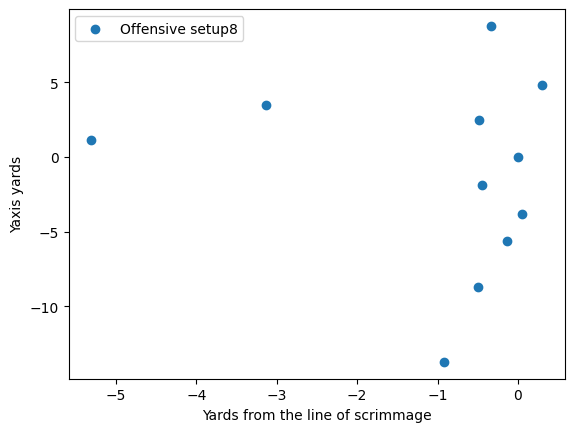

In [315]:
primary_df=offensive_df.filter((pl.col("losDist")<250) & (pl.col("losDist")>=-200))
secondary_df=offensive_df.filter((pl.col("losDist")<-200))
joint_df=pl.DataFrame()
suffixes=["secondary","tertiary"]
i=-2
#Combine them together after sorting by y-axis value. This prevents y-axis swapping between levels of the defense from messing up the GMM
for evaluation_df in [primary_df,secondary_df]:
    i+=1
    evaluation_df=evaluation_df.select(pl.all().sort_by("hDist").over("playgameID"))
    evaluation_df=evaluation_df.group_by('playgameID').agg(pl.col('yardsGained').first(),pl.col('winPercentChange').first(),pl.col('hDist','losDist'))
    evaluation_df=evaluation_df.with_columns(pl.col("hDist").list.len().alias("primary_players"))
    evaluation_df=evaluation_df.select(pl.all().sort_by("primary_players"))
    #print(evaluation_df["primary_players"].hist(bins=range(12)))
    if joint_df.is_empty():
        joint_df=evaluation_df
    else:
        joint_df=joint_df.join(evaluation_df,on="playgameID",suffix=suffixes[i],how="left")
#Reaggreate the feature columns
joint_df=joint_df.with_columns(pl.concat_list("hDist", "hDistsecondary").alias("allhDist"))
joint_df=joint_df.with_columns(pl.concat_list("losDist", "losDistsecondary").alias("alllosDist"))
joint_df=joint_df.with_columns((pl.col("primary_players")+pl.col("primary_playerssecondary")).alias("player_totals"))
#Keep only the columns with 11 players
joint_df=joint_df.filter(pl.col("player_totals")==11)
n_components=4
gmm_df=joint_df#.filter((pl.col("primary_players")>2) & (pl.col("primary_players")<10))
gmm_df=gmm_df.select(["allhDist","alllosDist","playgameID"])
gmm_df=gmm_df.to_numpy()
#We really only want the Y features at this point. We know they are at the line of scrimmage
#Define the features and fit the GMM
#np.abs potentially to prevent reflections from being different
y_feats=np.concatenate(gmm_df[:,0]).ravel().reshape(-1,11)
x_feats=np.concatenate(gmm_df[:,1]).ravel().reshape(-1,11)
gmm_features=np.concatenate([y_feats,x_feats],1)
n_components=8
gm_off = GaussianMixture(n_components=n_components, random_state=0).fit(gmm_features)
joint_df=joint_df.with_columns(offensive_setup=gm_off.predict(gmm_features))

#Plot the means for player placement
plotting=0
if plotting:
    for j in range(n_components):
        plt.figure()
        #Goes to 11 because there are 11 players on field
        plt.scatter(gm.means_[j,11:((2*11))]/100,gm.means_[j,0:11]/100)
        plt.legend(["Offensive setup"+str(j+1)])
        plt.xlabel("Yards from the line of scrimmage")
        plt.ylabel("Yaxis yards")
    gmm_offensive=joint_df

In [ ]:
#Now the matching, I'd like to make a matrix of offensive set ups vs. defensive set ups and compute the expected yardage. 
#1. I'll need to reassign the GMM components back to the dataframe so that the playgameId can be referenced. 
#2. Get histograms of the yardage vs. setup
#3. After this I could predict the yardage but perhaps only later

In [310]:
combined_gmm=gmm_offensive.join(gmm_defensive,on="playgameID",how="left",coalesce=True)

shape: (10, 3)
┌────────────┬───────────────┬───────┐
│ breakpoint ┆ category      ┆ count │
│ ---        ┆ ---           ┆ ---   │
│ f64        ┆ cat           ┆ u32   │
╞════════════╪═══════════════╪═══════╡
│ 0.7        ┆ (-0.007, 0.7] ┆ 156   │
│ 1.4        ┆ (0.7, 1.4]    ┆ 582   │
│ 2.1        ┆ (1.4, 2.1]    ┆ 581   │
│ 2.8        ┆ (2.1, 2.8]    ┆ 0     │
│ 3.5        ┆ (2.8, 3.5]    ┆ 367   │
│ 4.2        ┆ (3.5, 4.2]    ┆ 351   │
│ 4.9        ┆ (4.2, 4.9]    ┆ 0     │
│ 5.6        ┆ (4.9, 5.6]    ┆ 824   │
│ 6.3        ┆ (5.6, 6.3]    ┆ 310   │
│ 7.0        ┆ (6.3, 7.0]    ┆ 612   │
└────────────┴───────────────┴───────┘
shape: (10, 3)
┌────────────┬───────────────┬───────┐
│ breakpoint ┆ category      ┆ count │
│ ---        ┆ ---           ┆ ---   │
│ f64        ┆ cat           ┆ u32   │
╞════════════╪═══════════════╪═══════╡
│ 0.7        ┆ (-0.007, 0.7] ┆ 42    │
│ 1.4        ┆ (0.7, 1.4]    ┆ 923   │
│ 2.1        ┆ (1.4, 2.1]    ┆ 361   │
│ 2.8        ┆ (2.1, 2.8]    ┆ 0  

In [322]:
worst_matchup=[100000,-1,-1]
best_matchup=[-100000,-1,-1]
for i in range(8):
    for j in range(8):
        temp=combined_gmm.filter((pl.col("defensive_setup")==float(j)) & (pl.col("offensive_setup")==float(i)))
        #print(i,j,temp.shape[0],temp["yardsGained"].mean())
        if temp.shape[0]>100:
            if temp["yardsGained"].mean()>best_matchup[0]:
                best_matchup=[temp["yardsGained"].mean(),i,j]
            if temp["yardsGained"].mean()<worst_matchup[0]:
                worst_matchup=[temp["yardsGained"].mean(),i,j]

[7.1440677966101696, 1, 1]
[3.9705882352941178, 7, 3]


Text(0.5, 1.0, 'Worst matchup for the offense')

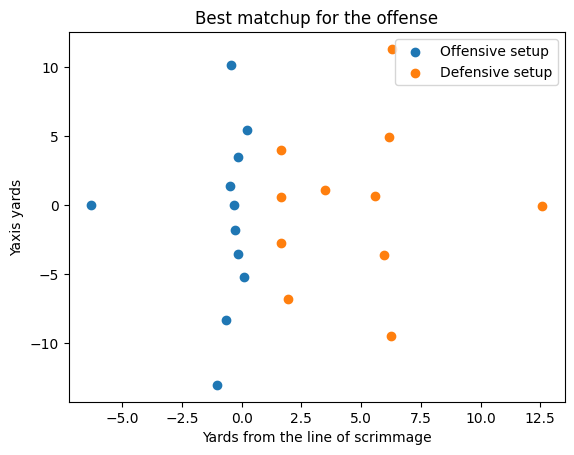

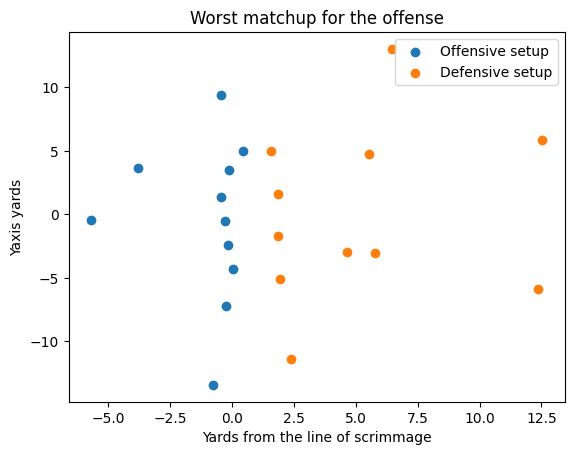

In [324]:
print(best_matchup)
print(worst_matchup)
plt.figure()
#Goes to 11 because there are 11 players on field
plt.scatter(gm_off.means_[best_matchup[1],11:((2*11))]/100,gm_off.means_[best_matchup[1],0:11]/100)
plt.scatter(gm_def.means_[best_matchup[2],11:((2*11))]/100,gm_def.means_[best_matchup[2],0:11]/100)
plt.legend(["Offensive setup","Defensive setup"])
plt.xlabel("Yards from the line of scrimmage")
plt.ylabel("Yaxis yards")
plt.title("Best matchup for the offense")

plt.figure()
#Goes to 11 because there are 11 players on field
plt.scatter(gm_off.means_[worst_matchup[1],11:((2*11))]/100,gm_off.means_[worst_matchup[1],0:11]/100)
plt.scatter(gm_def.means_[worst_matchup[2],11:((2*11))]/100,gm_def.means_[worst_matchup[2],0:11]/100)
plt.legend(["Offensive setup","Defensive setup"])
plt.xlabel("Yards from the line of scrimmage")
plt.ylabel("Yaxis yards")
plt.title("Worst matchup for the offense")

In [ ]:
#I am not a football expert. It looks like the best matchup for the offense is if the defense leaves an edge receiver uncovered. Likely in a prevent. 
#The worst matchup looks like preparation for a short run up the middle. 
#Neat. The real interesting analysis lies in the counterfactuals and #conditionals.
#I.e. the defense comes out in formation 6. What should our formation be? Can easily plot the best conditonals to find out. 